# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [1]:
import os
import cv2
from atom import ATOMClassifier
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset preprocessing

In [2]:
data = []
labels = []
path = '../data/images'
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(os.path.join(path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    data.append(img)
    labels.append(int(file[:3]) - 1)

label_dict = {0: 'Danaus plexippus',
              1: 'Heliconius charitonius',
              2: 'Heliconius erato',
              3: 'Junonia coenia',
              4: 'Lycaena phlaeas',
              5: 'Nymphalis antiopa',
              6: 'Papilio cresphontes',
              7: 'Pieris rapae',
              8: 'Vanessa atalanta',
              9: 'Vanessa cardui'}
data = np.array(data) / 255.0
labels = np.array(labels)
flatten_data = data.reshape(len(data), -1)
categorical_labels = F.one_hot(torch.tensor(labels, requires_grad=False), num_classes=10).numpy()

In [6]:
print([label_dict[labels[i]] for i in range(10)]) 

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


#### display some samples

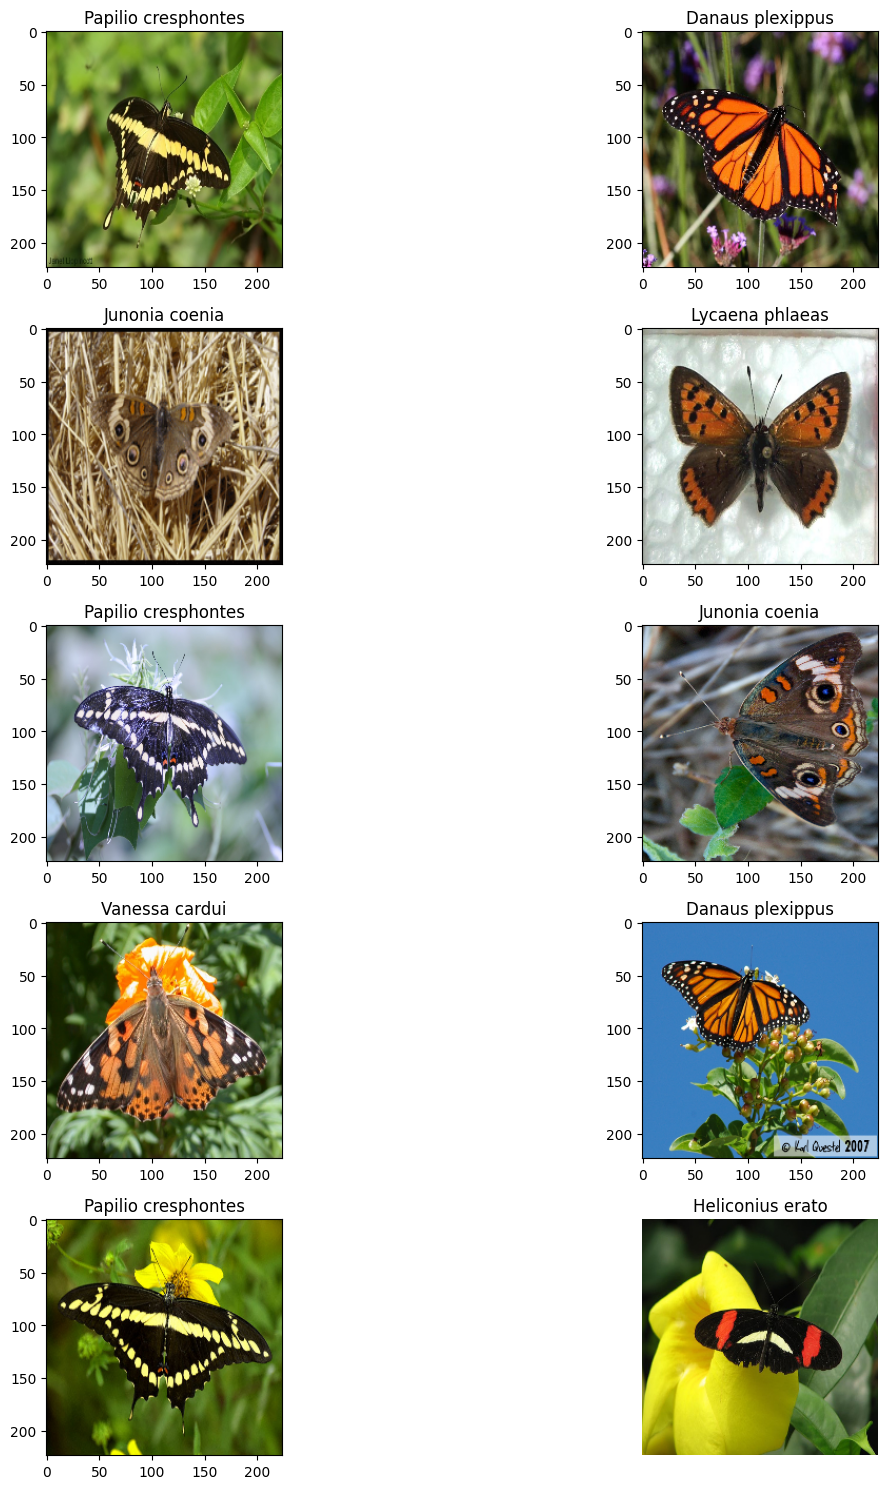

In [8]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(label_dict[labels[l]]))
plt.axis('off')        
plt.tight_layout()

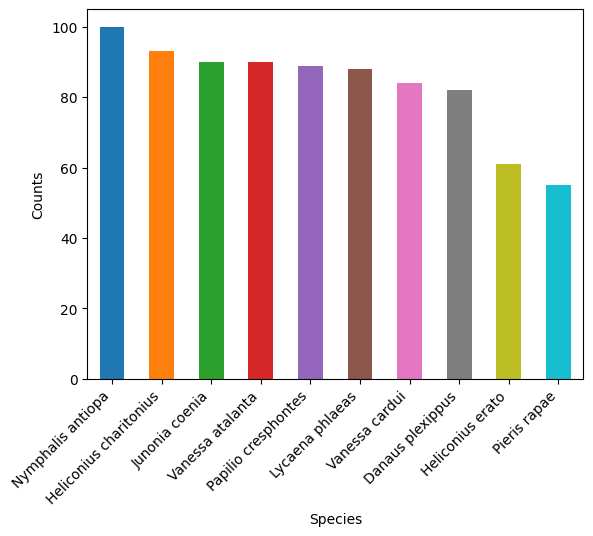

In [16]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = df['labels'].map(label_dict)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

## Data cleaning

For a classification task, you can follow these steps in the given order to ensure your data is clean and ready for modeling:

* **Standard Data Cleaning**: Drop columns with specific data types, strip categorical features, drop duplicate rows, and handle missing values.
* **Balancing the Data**: Use the Balancer class to address any class imbalance.
* **Encoding Categorical Features**: Convert categorical data into numerical values1.
* **Imputing Missing Values**: Handle any remaining missing values.
* **Handling Outliers**: Detect and manage outliers in your dataset.
* **Scaling the Feature Set**: Standardize your dataset to ensure all features are on a similar scale.

This sequence helps in systematically preparing your data for a classification model.

In [17]:
atom = ATOMClassifier(flatten_data, categorical_labels,
                      test_size=0.2,
                      n_jobs=-1,
                      device=('gpu' if device == 'cuda' else 'cpu'),
                      engine='cuml',
                      verbose=2,
                      random_state=1)

ModuleNotFoundError: Failed to import cuml. Package is not installed. Refer to: https://rapids.ai/start.html#install.